n_batches = number of batches
n_voxels = voxel num in batch = 9659
n_points = total number of points, same as the number of coords = 98679

C = Hidden dimension = 128

voxel_feats.shape = torch.Size([9659, 128])
voxel_coors.shape = torch.Size([9659, 4]) # index_in_batch, z, y, x
len(points) = 4
points[0].shape = torch.Size([23048, 4]) # x, y, z, i
coors.shape = torch.Size([98679, 4]) # index_in_batch, z, y, x
len(img_metas) = 4
img_metas[0]["lidar2img"][0] =
array([[ 1.24367274e+03,  8.39585846e+02,  3.40926992e+01,
        -3.35141399e+02],
       [-1.72077022e+01,  5.37943490e+02, -1.22504977e+03,
        -6.27351052e+02],
       [-1.08974133e-02,  9.98430293e-01,  5.49381210e-02,
        -4.03011007e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [78]:
%matplotlib widget
from mmdet3d.datasets import build_dataset
from tools.misc.browse_dataset import build_data_cfg
from mmdet3d.models import apply_3d_transformation
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import copy
import torch
import numpy as np
from mmdet3d.ops.voxel.voxelize import voxelization
from mmdet3d.ops import DynamicScatter
import time
import pickle

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [80]:
with open("sst_input_layer.pkl", "rb") as f:
    sst_input_layer = pickle.load(f)


In [81]:
voxel_feats, voxel_coors, voxel_mean, img_metas, batch_size = sst_input_layer

In [82]:
def proj_points_to_2d(points, proj_mat):
    points = torch.cat(
        [
            points[:, :3].reshape(-1, 3),
            torch.ones((points.shape[0], 1), device=points.device),
        ],
        axis=-1,
    )
    points_2d = torch.mm(points, proj_mat.T)
    points_2d[:, 2] = points_2d[:, 2].clip(min=1e-4, max=1e4)
    points_2d[:, 0] /= points_2d[:, 2]
    points_2d[:, 1] /= points_2d[:, 2]
    return points_2d

def points_in_image(points, image_size=(1600, 900)):
    return (
        (0 <= points[:, 0])
        & (points[:, 0] <= image_size[0])
        & (0 <= points[:, 1])
        & (points[:, 1] <= image_size[1])
    )

In [83]:
start_time = time.time()
# Get projection matrix
proj_mats = [
    torch.Tensor(img_meta["lidar2img"][0].reshape(4, 4)).to(voxel_mean.device)
    for img_meta in img_metas
]
print(time.time() - start_time)

0.001466512680053711


In [84]:
start_time = time.time()
# Find batch ranges
batch_start_inds = [
    torch.where(voxel_coors[:, 0] == b)[0][0] for b in range(batch_size)
]
batch_ranges = [
    (batch_start_inds[b], batch_start_inds[b + 1])
    for b in range(batch_size - 1)
]
batch_ranges.append((batch_start_inds[-1], voxel_coors.shape[0]))
print(time.time() - start_time)

0.002499103546142578


In [85]:
start_time = time.time()
# Project voxel mean to 2d
voxel_mean_2d = torch.zeros_like(voxel_mean)
for batch_range, proj_mat in zip(batch_ranges, proj_mats):
    voxel_mean_2d[batch_range[0] : batch_range[1], :] = proj_points_to_2d(
        voxel_mean[batch_range[0] : batch_range[1], :], proj_mat
    )
print(time.time() - start_time)

0.002619504928588867


In [89]:
# Filter out points outside image
is_voxel_mean_in_image = points_in_image(voxel_mean_2d)
voxel_mean_2d_in_image = voxel_mean_2d[is_voxel_mean_in_image, :]
voxel_coors = voxel_coors[is_voxel_mean_in_image, :]
voxel_feats = voxel_feats[is_voxel_mean_in_image, :]

# Compute new batch ranges for filtered voxels
batch_start_inds = [
    torch.where(voxel_coors[:, 0] == b)[0][0] for b in range(batch_size)
]
batch_ranges = [
    (batch_start_inds[b], batch_start_inds[b + 1])
    for b in range(batch_size - 1)
]
batch_ranges.append((batch_start_inds[-1], voxel_coors.shape[0]))

print(batch_ranges)

[(tensor(0, device='cuda:0'), tensor(593, device='cuda:0')), (tensor(593, device='cuda:0'), tensor(1162, device='cuda:0')), (tensor(1162, device='cuda:0'), tensor(1515, device='cuda:0')), (tensor(1515, device='cuda:0'), 2072)]


In [97]:
voxel_coors[:, 0]

tensor([0., 0., 0.,  ..., 3., 3., 3.], device='cuda:0')

In [101]:
# Create coordinates in image plane based on projected voxel mean
voxel_mean_2d_coords = voxel_mean_2d_in_image.flip(1).int()
voxel_mean_2d_coords[:, 0] = voxel_coors[:, 0]
voxel_mean_2d_coords[:, 1] = 0

In [102]:
voxel_mean_2d_coords

tensor([[  0,   0, 866,  12],
        [  0,   0, 887, 127],
        [  0,   0, 878, 251],
        ...,
        [  3,   0, 441, 501],
        [  3,   0, 442, 509],
        [  3,   0, 490, 548]], device='cuda:0', dtype=torch.int32)

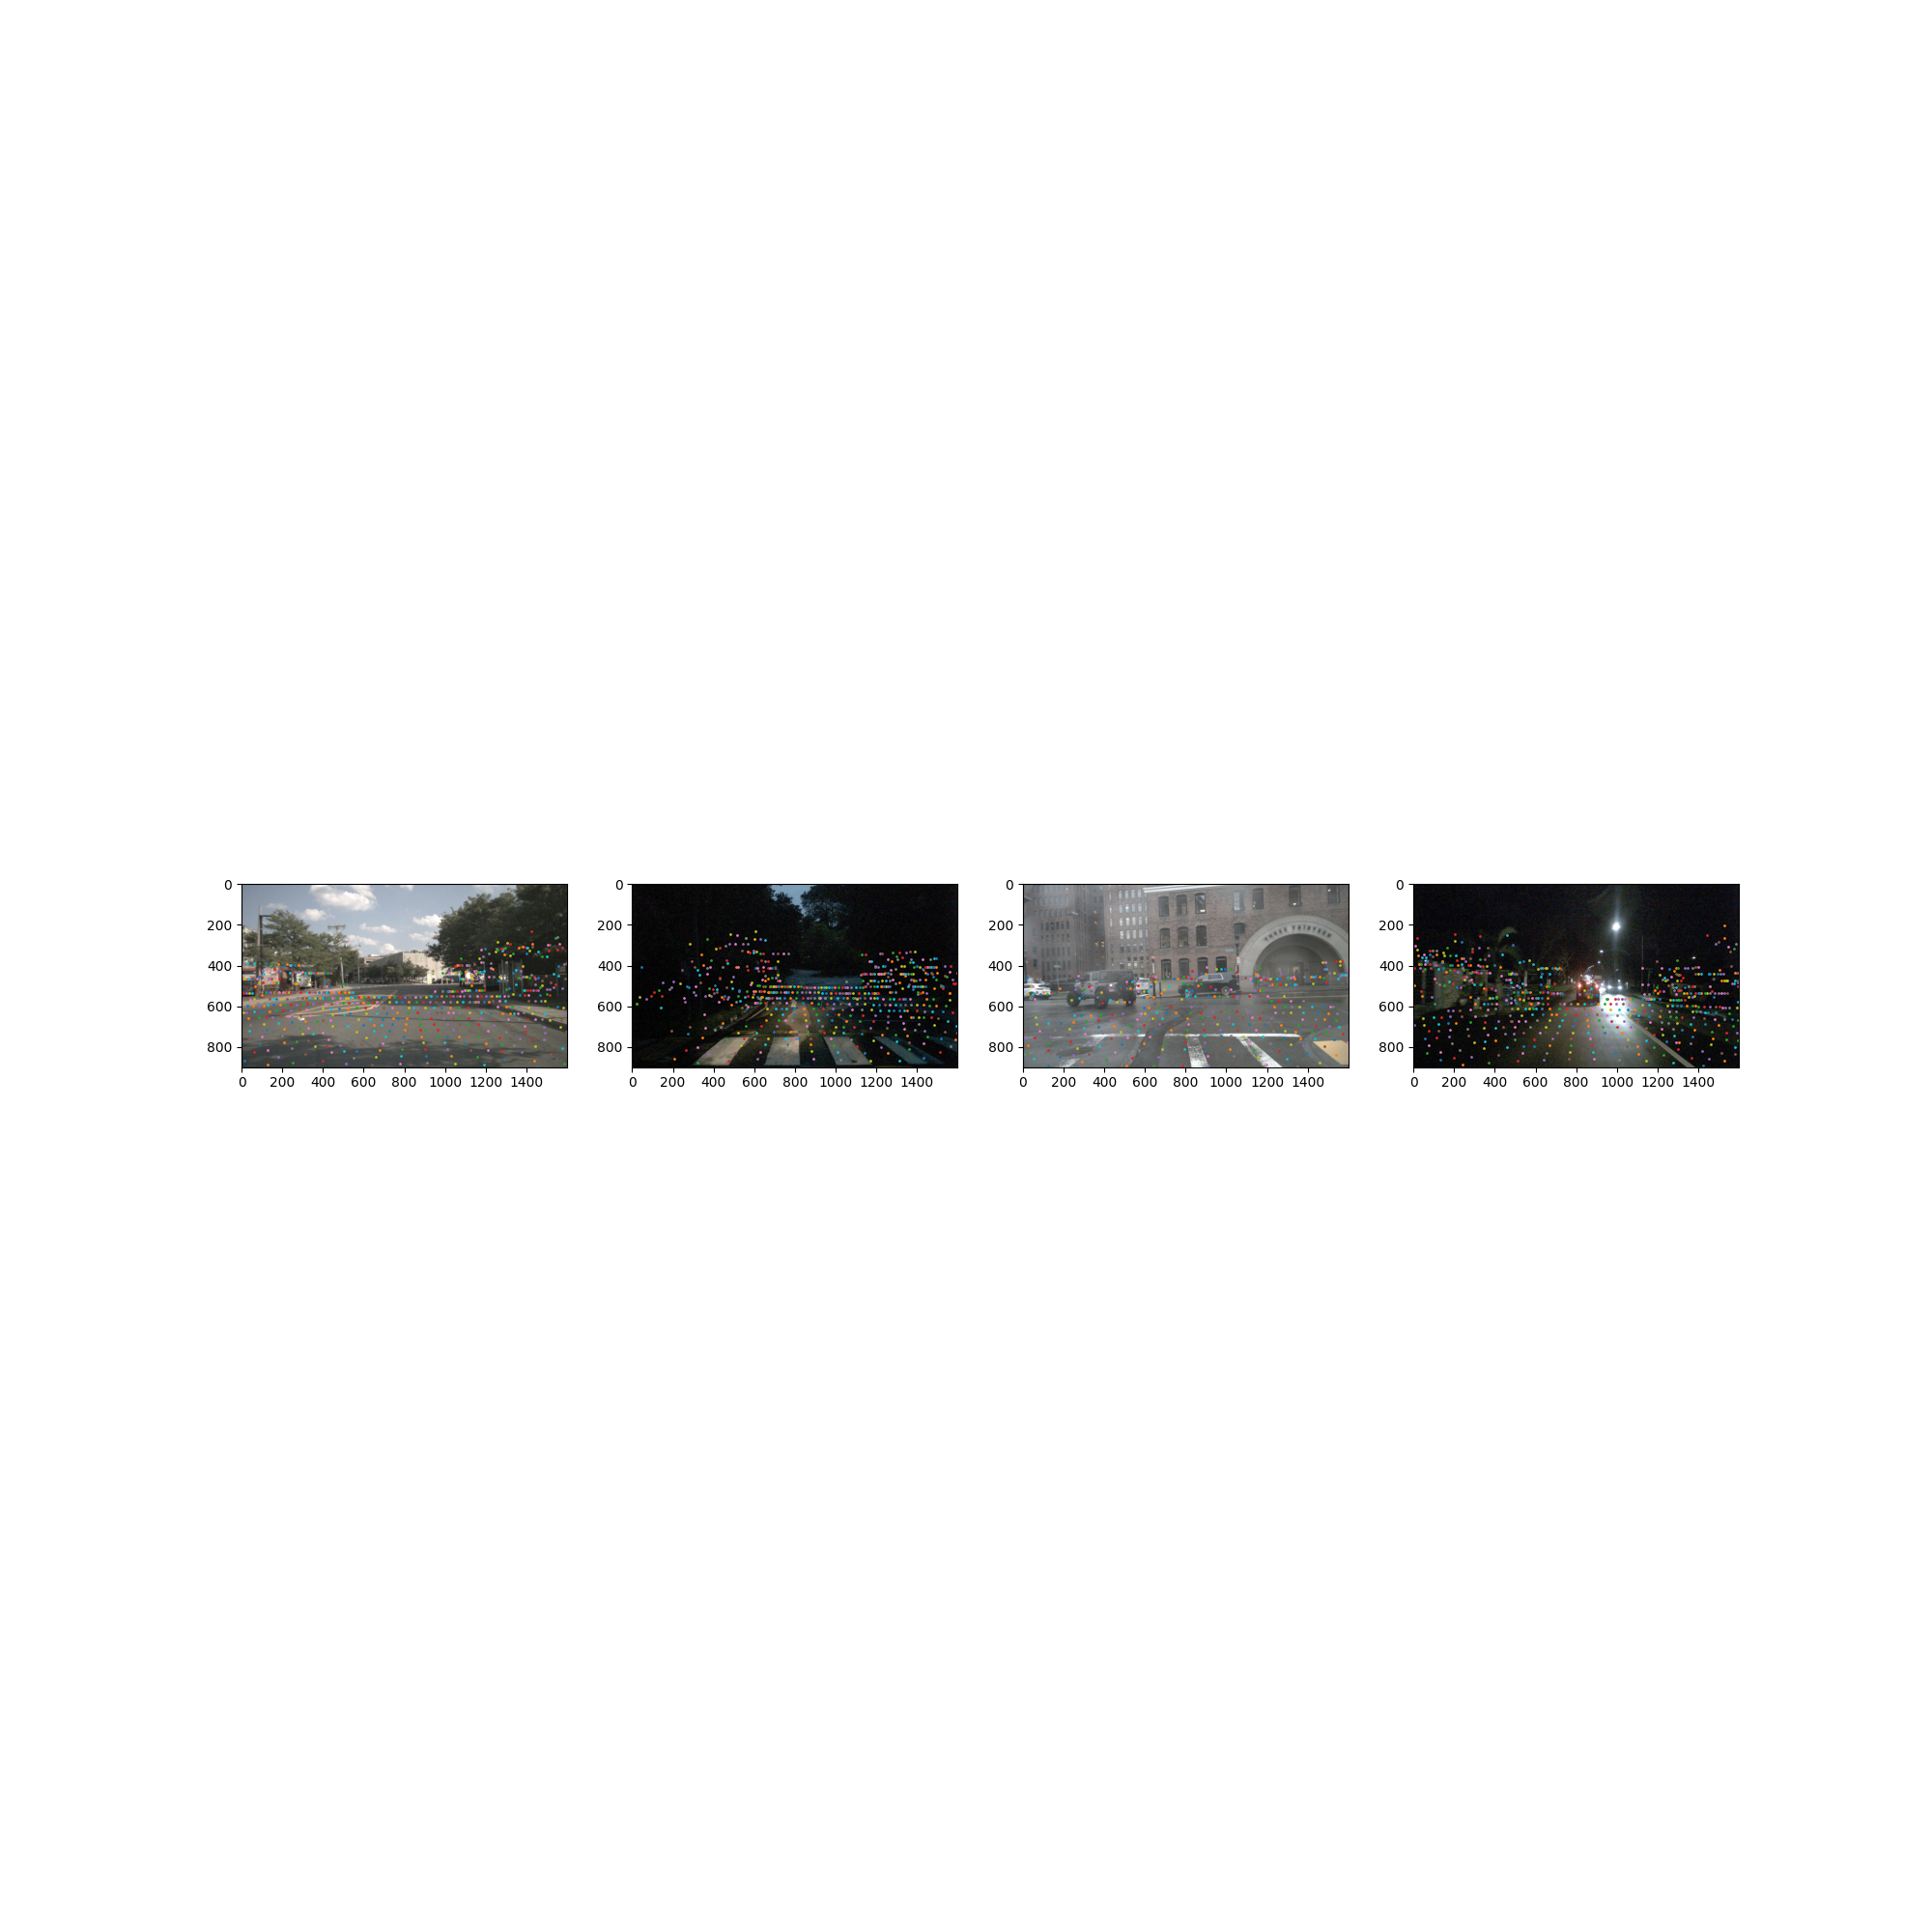

In [103]:
# Create subplots for each batch
fig, axs = plt.subplots(1, batch_size, figsize=(20, 20))
for i in range(batch_size):
    im = plt.imread(img_metas[i]["filename"][0])
    axs[i].imshow(im)

for voxel_mean_2d in voxel_mean_2d_coords:
    axs[voxel_mean_2d[0]].scatter(voxel_mean_2d.cpu()[3], voxel_mean_2d.cpu()[2], s=1)

plt.show()
    

In [92]:
batch_range = batch_ranges[0]
print(voxel_mean_2d_in_image.cpu()[batch_range[0] : batch_range[1]])
print(voxel_mean_2d_in_image.cpu()[batch_range[0] : batch_range[1]].shape)

tensor([[ 12.8636, 866.9570,   4.8921,   1.0000],
        [127.2620, 887.4098,   4.6382,   1.0000],
        [251.5854, 878.6818,   4.7464,   1.0000],
        ...,
        [434.8562, 501.6403,  41.2645,   1.0000],
        [506.1252, 532.0312,  41.1827,   1.0000],
        [499.6923, 486.9220,  44.9683,   1.0000]])
torch.Size([593, 4])


In [93]:
voxel_mean_2d_coords

tensor([[  0,   0, 866,  12],
        [  0,   0, 887, 127],
        [  0,   0, 878, 251],
        ...,
        [  0,   0, 441, 501],
        [  0,   0, 442, 509],
        [  0,   0, 490, 548]], device='cuda:0', dtype=torch.int32)